# Anchor explanations - ALIBI Explain framework

## Theoretical Explanation

References:
* https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_image_imagenet.html
* https://www.kaggle.com/general/226091
* https://homes.cs.washington.edu/~marcotcr/aaai18.pdf
* https://github.com/SeldonIO/alibi/blob/master/doc/source/methods/Anchors.ipynb

Similar to LIME, images are first segmented into superpixels, maintaining local image structure. The interpretable representation then consists of the presence or absence of each superpixel in the anchor. It is crucial to generate meaningful superpixels in order to arrive at interpretable explanations. The algorithm supports a number of standard image segmentation algorithms (felzenszwalb, slic and quickshift) and allows the user to provide a custom segmentation function.

The superpixels not present in a candidate anchor can be masked in 2 ways:
* Take the average value of that superpixel.
* Use the pixel values of a superimposed picture over the masked superpixels.

<img src="https://github.com/SeldonIO/alibi/raw/568efc77ee591461a49ea8f704a150b295339bc1/doc/source/methods/anchor_image.png" width="900">

## Tensorflow General configs and imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 

In [3]:
import numpy as np
import tensorflow as tf
import pathlib
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from alibi.explainers import AnchorImage

## Data pre-processing

In [4]:
# Obtain and prepare dataset

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [5]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Transfer Learning on Xception model

In [6]:
# create the base pre-trained model
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

83697664/83683744 [==============================] - 1s 0us/step


In [7]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# this is the model we will train
xception_model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [10]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

xception_model.load_weights('../input/xceptionmodeltf/xceptionmodeltfv2')

In [11]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

xception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [12]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 95s 81ms/step - loss: 0.3508 - accuracy: 0.8814 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 2/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3374 - accuracy: 0.8853 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 3/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.3858 - val_accuracy: 0.8590
Epoch 4/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3091 - accuracy: 0.8945 - val_loss: 0.3776 - val_accuracy: 0.8624
Epoch 5/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2981 - accuracy: 0.8983 - val_loss: 0.3711 - val_accuracy: 0.8636
Epoch 6/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.3658 - val_accuracy: 0.8677
Epoch 7/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2804 - accuracy: 0.9043 - val_loss: 0.3615 -

<AxesSubplot:>

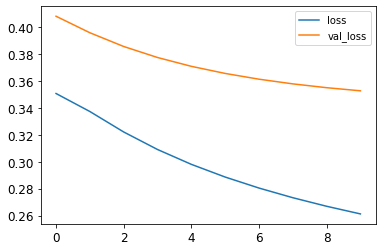

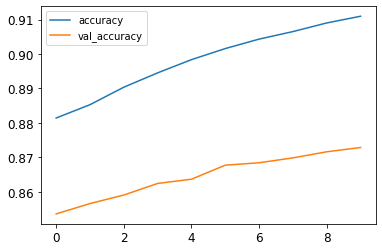

In [13]:
# Results visualization
# Loss and validation loss variation 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [14]:
#Save the previous trained model

modelSaving = xception_model.save_weights('./xceptionmodel', save_format='h5')

In [15]:
#test sample evaluation

score = xception_model.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 3s 30ms/step - loss: 0.3263 - accuracy: 0.8835
Test loss:  0.3263017535209656
Test accuracy:  0.8835227489471436


## Anchor Explanations Implementation

In [16]:
# Define prediction function

predict_fn = lambda x: xception_model.predict(x)
image_shape = (124, 124, 3)

In [17]:
# Initialize anchor image explainer
# The segmentation function will be used to generate superpixels. 
# It is important to have meaningful superpixels in order to generate a useful explanation
# Please check scikit-image’s segmentation methods (felzenszwalb, slic and quickshift built in the explainer) for more information.
# https://scikit-image.org/docs/dev/api/skimage.segmentation.html

segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

### Get 3 random different images

In [18]:
for images, labels in train_ds.take(1):
    for i in range(1):
        imageSelected = images[i].numpy().astype("float32")
        imageLabel = class_names[labels[i]]
        imageSelected2 = images[i - 1].numpy().astype("float32")
        imageLabel2 = class_names[labels[i - 1]]
        imageSelected3 = images[i - 2].numpy().astype("float32")
        imageLabel3 = class_names[labels[i - 2]]

### Image 1:

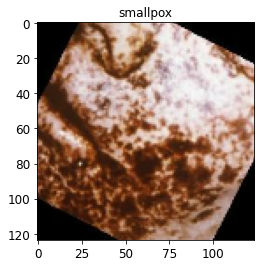

In [19]:
plt.title(imageLabel)
plt.imshow(imageSelected);

In [20]:
explanation = explainer.explain(imageSelected, threshold=.95, p_sample=.5, tau=0.25)

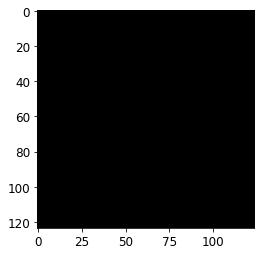

In [21]:
plt.imshow(explanation.anchor);

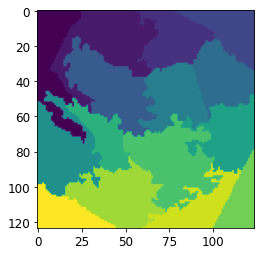

In [22]:
plt.imshow(explanation.segments);

### Image 2:

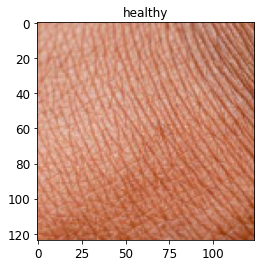

In [23]:
plt.title(imageLabel2)
plt.imshow(imageSelected2);

In [24]:
explanation = explainer.explain(imageSelected2, threshold=.95, p_sample=.5, tau=0.25)

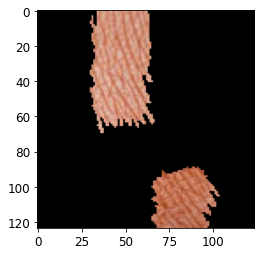

In [25]:
plt.imshow(explanation.anchor);

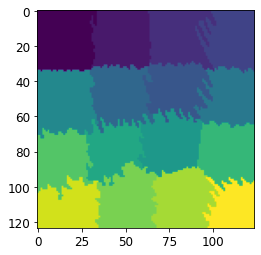

In [26]:
plt.imshow(explanation.segments);

### Image 3:

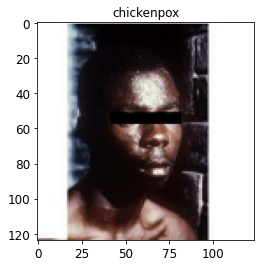

In [27]:
plt.title(imageLabel3)
plt.imshow(imageSelected3);

In [28]:
explanation = explainer.explain(imageSelected3, threshold=.95, p_sample=.5, tau=0.25)

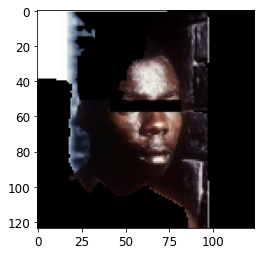

In [29]:
plt.imshow(explanation.anchor);

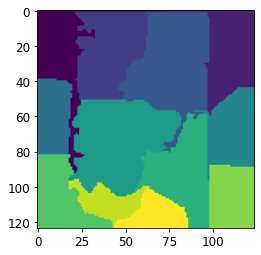

In [30]:
plt.imshow(explanation.segments);